### start

In [6]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.entry_helpers as h
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    sime,
    wm, sm, wo,
    h,
    wime,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

[09/Aug/25 17:04:21] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[09/Aug/25 17:04:21] MILESTONE [1067068951.<module>:136] Good morning, let's get to work


# Model Training

## Concatenated Model Sequence

#### load all local data

In [7]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

[09/Aug/25 17:04:23] INFO [workflow_orchestrator.load_all_training_data:101] Auto-detected date_suffixes from config: ['201122', '201222', '210121', '210220', '210322', '210421', '210521', '210620', '210720', '210819', '210918', '211018', '211117', '211217', '220116', '220215', '220317', '220416', '220516', '220615', '220715', '220814', '220913', '221013', '221112', '221212', '230111', '230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '231207', '240106', '240205', '240306', '240405', '240505', '240604', '240704', '240803', '241002', '241201', '250130', '250331', '240902', '241101', '241231', '250301', '250430']
[09/Aug/25 17:04:23] MILESTONE [workflow_orchestrator.load_all_training_data:118] <PROD> Loading training data for 55 periods: ['201122', '201222', '210121', '210220', '210322', '210421', '210521', '210620', '210720', '210819', '210918', '211018', '211117', '211217', '220116', '220215', '220317', '220416', '220516', '220615', '22

#### preprocess and concatenate

In [8]:
results = workflow_orch.preprocess_all_training_data()

[09/Aug/25 17:04:30] INFO [workflow_orchestrator.preprocess_all_training_data:156] Preprocessing 55 date periods...
[09/Aug/25 17:04:30] INFO [wallet_preprocessor.preprocess_training_data:74] Starting preprocessing for SageMaker XGBoost compatibility...
[09/Aug/25 17:04:30] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 110 columns for x_train.
[09/Aug/25 17:04:31] INFO [wallet_preprocessor._save_preprocessed_df:415] Saved preprocessed train split to ../s3_uploads/wallet_training_data_preprocessed/dda_953_rebuild/201122/train.csv
[09/Aug/25 17:04:31] INFO [wallet_preprocessor._save_preprocessed_df:415] Saved preprocessed train_y split to ../s3_uploads/wallet_training_data_preprocessed/dda_953_rebuild/201122/train_y.csv
[09/Aug/25 17:04:31] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed train: 6,180 rows × 231 cols.
[09/Aug/25 17:04:31] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 110 columns for x_test.
[09

In [9]:
workflow_orch.concatenate_all_preprocessed_data(repreprocess_offsets=False)

[09/Aug/25 17:10:50] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:202] Loading preprocessed training data...
[09/Aug/25 17:11:30] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:205] Beginning concatenation of preprocessed data...
[09/Aug/25 17:16:46] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:266] Saved concatenated train.csv.gz with 1225229 rows to ../s3_uploads/wallet_training_data_concatenated/dda_953_rebuild/train.csv.gz
[09/Aug/25 17:16:59] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:266] Saved concatenated eval.csv.gz with 47086 rows to ../s3_uploads/wallet_training_data_concatenated/dda_953_rebuild/eval.csv.gz
[09/Aug/25 17:17:36] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:266] Saved concatenated test.csv.gz with 141236 rows to ../s3_uploads/wallet_training_data_concatenated/dda_953_rebuild/test.csv.gz
[09/Aug/25 17:21:07] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:266] Sav

#### inspect features

In [ ]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/eval.csv.gz')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

#### upload

In [10]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[09/Aug/25 17:21:49] INFO [workflow_orchestrator.upload_concatenated_training_data:378] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[09/Aug/25 17:21:49] INFO [workflow_orchestrator.upload_concatenated_training_data:381] Uploading concatenated splits in parallel with 4 threads...
[09/Aug/25 17:21:49] INFO [workflow_orchestrator._upload_split:402] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-953-rebuild/train.csv.gz', proceeding with upload...
[09/Aug/25 17:21:49] INFO [workflow_orchestrator._upload_split:402] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-953-rebuild/test.csv.gz', proceeding with upload...
[09/Aug/25 17:21:49] INFO [workflow_orchestrator._upload_split:402] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-953-rebuild/val.csv.gz', proceeding with upload...
[09/Aug/25 17:21:49] INFO [workflow_

### Epoch Shifts Sequence

#### train all epoch shifts

In [11]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_all_epoch_shift_models(concat_uris)

[09/Aug/25 17:59:46] INFO [workflow_orchestrator.upload_concatenated_training_data:378] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[09/Aug/25 17:59:46] INFO [workflow_orchestrator.upload_concatenated_training_data:381] Uploading concatenated splits in parallel with 4 threads...
[09/Aug/25 17:59:46] INFO [workflow_orchestrator._upload_split:395] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-953-rebuild/test.csv.gz
[09/Aug/25 17:59:47] INFO [workflow_orchestrator._upload_split:395] File exists, skipping upload of concatenated split 'val': training-data-concatenated/dda-953-rebuild/val.csv.gz
[09/Aug/25 17:59:47] INFO [workflow_orchestrator._upload_split:395] File exists, skipping upload of concatenated split 'train': training-data-concatenated/dda-953-rebuild/train.csv.gz
[09/Aug/25 17:59:47] INFO [workflow_orchestrator._upload_split:395] File exists, ski

2025-08-10 00:59:49 Starting - Starting the training job2025-08-10 00:59:49 Starting - Starting the training job2025-08-10 00:59:52 Starting - Starting the training job2025-08-10 00:59:49 Starting - Starting the training job....

[09/Aug/25 17:59:55] ERROR [session.submit:1061] Please check the troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html#sagemaker-python-sdk-troubleshooting-create-training-job
[09/Aug/25 17:59:56] WARNING [workflow_orchestrator._train_single_epoch_shift_with_retry:1156] Throttled on training epoch_shift=-60 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateTrainingJob operation (reached max retries: 4): Rate exceeded


2025-08-10 00:59:51 Starting - Starting the training job.2025-08-10 00:59:54 Starting - Starting the training job.2025-08-10 00:59:58 Starting - Starting the training job.2025-08-10 00:59:54 Starting - Starting the training job.2025-08-10 00:59:55 Starting - Starting the training job...................
2025-08-10 01:00:16 Starting - Preparing the instances for training
2025-08-10 01:00:15 Starting - Preparing the instances for training
2025-08-10 01:00:25 Downloading - Downloading input data
2025-08-10 01:00:17 Starting - Preparing the instances for training...

[09/Aug/25 18:00:26] INFO [workflow_orchestrator._train_single_epoch_shift:1128] Starting training for epoch_shift=-60
[09/Aug/25 18:00:26] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh-60, using standard training...
[09/Aug/25 18:00:26] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary Python version: py3.
[09/Aug/25 18:00:26] INFO [image_uris._processor:530] Ignoring unnecessary instance type: ml.m6i.2xlarge.


.

[09/Aug/25 18:00:26] INFO [wallet_script_modeler._train_single_period_script_model:142] Launching script-mode training job with custom targets: wscr-dda-953--sh-60-0809-180026
[09/Aug/25 18:00:26] INFO [telemetry_logging.wrapper:92] SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
[09/Aug/25 18:00:26] INFO [session.submit:1053] Creating training-job with name: wscr-dda-953--sh-60-0809-180026



2025-08-10 01:00:12 Starting - Preparing the instances for training.
2025-08-10 01:00:26 Downloading - Downloading input data.
2025-08-10 01:00:29 Downloading - Downloading input data.
2025-08-10 01:00:16 Starting - Preparing the instances for training.
2025-08-10 01:00:16 Starting - Preparing the instances for training.2025-08-10 01:00:28 Starting - Starting the training job.....................
2025-08-10 01:00:35 Downloading - Downloading input data
2025-08-10 01:00:36 Downloading - Downloading input data
2025-08-10 01:00:37 Downloading - Downloading input data....
2025-08-10 01:00:28 Downloading - Downloading input data.
2025-08-10 01:00:57 Downloading - Downloading the training image.
2025-08-10 01:00:59 Downloading - Downloading the training image.
2025-08-10 01:01:01 Downloading - Downloading the training image.
2025-08-10 01:01:00 Downloading - Downloading the training image.
2025-08-10 01:01:00 Downloading - Downloading input data.....................
2025-08-10 01:01:16 Trai

[09/Aug/25 18:03:43] ERROR [workflow_orchestrator.train_all_epoch_shift_models:505] Training failed for epoch_shift=-180
Traceback (most recent call last):
  File "/Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_modeling/workflow_orchestrator.py", line 501, in train_all_epoch_shift_models
    result = future.result()
             ^^^^^^^^^^^^^^^
  File "/Users/jeremymeadow/.pyenv/versions/3.11.9/lib/python3.11/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremymeadow/.pyenv/versions/3.11.9/lib/python3.11/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/Users/jeremymeadow/.pyenv/versions/3.11.9/lib/python3.11/concurrent/futures/thread.py", line 58, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_mod

[75]#011eval-aucpr:0.46803
[76]#011eval-aucpr:0.46763
[77]#011eval-aucpr:0.46799
[78]#011eval-aucpr:0.46777
[79]#011eval-aucpr:0.46938
[80]#011eval-aucpr:0.46959
[81]#011eval-aucpr:0.46962
[82]#011eval-aucpr:0.47071
[83]#011eval-aucpr:0.47091
[84]#011eval-aucpr:0.47279
[85]#011eval-aucpr:0.47298
[86]#011eval-aucpr:0.47326
[87]#011eval-aucpr:0.47300
[88]#011eval-aucpr:0.47263
[89]#011eval-aucpr:0.47232
[90]#011eval-aucpr:0.47302
[91]#011eval-aucpr:0.47236
[92]#011eval-aucpr:0.47173
[93]#011eval-aucpr:0.47314
[94]#011eval-aucpr:0.47625
[95]#011eval-aucpr:0.47704
[96]#011eval-aucpr:0.47746
[97]#011eval-aucpr:0.47863


[09/Aug/25 18:03:46] ERROR [workflow_orchestrator.train_all_epoch_shift_models:505] Training failed for epoch_shift=-240
Traceback (most recent call last):
  File "/Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_modeling/workflow_orchestrator.py", line 501, in train_all_epoch_shift_models
    result = future.result()
             ^^^^^^^^^^^^^^^
  File "/Users/jeremymeadow/.pyenv/versions/3.11.9/lib/python3.11/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremymeadow/.pyenv/versions/3.11.9/lib/python3.11/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/Users/jeremymeadow/.pyenv/versions/3.11.9/lib/python3.11/concurrent/futures/thread.py", line 58, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_mod

[73]#011eval-aucpr:0.52097
[74]#011eval-aucpr:0.52125
[75]#011eval-aucpr:0.52283
[76]#011eval-aucpr:0.52320
[77]#011eval-aucpr:0.52478
[78]#011eval-aucpr:0.52540
[79]#011eval-aucpr:0.52571
[80]#011eval-aucpr:0.52466
[81]#011eval-aucpr:0.52605
[82]#011eval-aucpr:0.52656
[83]#011eval-aucpr:0.52596
[84]#011eval-aucpr:0.52636
[85]#011eval-aucpr:0.52651
[86]#011eval-aucpr:0.52621
[87]#011eval-aucpr:0.52493
[88]#011eval-aucpr:0.52527
[89]#011eval-aucpr:0.52406
[90]#011eval-aucpr:0.52428
[91]#011eval-aucpr:0.52522
[54]#011eval-aucpr:0.46688
[55]#011eval-aucpr:0.46791
[56]#011eval-aucpr:0.46830
[57]#011eval-aucpr:0.46742
[58]#011eval-aucpr:0.46831
[59]#011eval-aucpr:0.46961
[60]#011eval-aucpr:0.47059
[61]#011eval-aucpr:0.47255
[62]#011eval-aucpr:0.47237
[63]#011eval-aucpr:0.47243
[64]#011eval-aucpr:0.47343
[65]#011eval-aucpr:0.47326
[66]#011eval-aucpr:0.47473
[67]#011eval-aucpr:0.47296
[68]#011eval-aucpr:0.47603
[69]#011eval-aucpr:0.47697
[70]#011eval-aucpr:0.47869
[71]#011eval-aucpr:0.48053
[

[09/Aug/25 18:04:14] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh240/wscr-dda-953--sh240-0809-175947/output/model.tar.gz
[09/Aug/25 18:04:14] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=240


[144]#011eval-aucpr:0.48426
[145]#011eval-aucpr:0.48386
[146]#011eval-aucpr:0.48296
[147]#011eval-aucpr:0.48359
[148]#011eval-aucpr:0.48450
[149]#011eval-aucpr:0.48389
[150]#011eval-aucpr:0.48296
[151]#011eval-aucpr:0.48244
[152]#011eval-aucpr:0.48278
[153]#011eval-aucpr:0.48377
[154]#011eval-aucpr:0.48340
[155]#011eval-aucpr:0.48345
[156]#011eval-aucpr:0.48309
[157]#011eval-aucpr:0.48358
[158]#011eval-aucpr:0.48392
[159]#011eval-aucpr:0.48461
[160]#011eval-aucpr:0.48500
[161]#011eval-aucpr:0.48419
[162]#011eval-aucpr:0.48359
[163]#011eval-aucpr:0.48392
[164]#011eval-aucpr:0.48495
[165]#011eval-aucpr:0.48593
[166]#011eval-aucpr:0.48758
[167]#011eval-aucpr:0.48685
[131]#011eval-aucpr:0.53675
[132]#011eval-aucpr:0.53682
[133]#011eval-aucpr:0.53518
[134]#011eval-aucpr:0.53520
[135]#011eval-aucpr:0.53556
[136]#011eval-aucpr:0.53382
[137]#011eval-aucpr:0.53318
[138]#011eval-aucpr:0.53351
[139]#011eval-aucpr:0.53286
[140]#011eval-aucpr:0.53263
[141]#011eval-aucpr:0.53409
[142]#011eval-aucpr:

[09/Aug/25 18:04:19] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh180/wscr-dda-953--sh180-0809-175947/output/model.tar.gz
[09/Aug/25 18:04:19] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=180


[78]#011eval-aucpr:0.74936
[79]#011eval-aucpr:0.75174
[80]#011eval-aucpr:0.75153
[81]#011eval-aucpr:0.75281
[82]#011eval-aucpr:0.75133
[83]#011eval-aucpr:0.74784
[84]#011eval-aucpr:0.74866
[85]#011eval-aucpr:0.74993
[86]#011eval-aucpr:0.75051
[87]#011eval-aucpr:0.75095
[88]#011eval-aucpr:0.74936
[89]#011eval-aucpr:0.75062
[90]#011eval-aucpr:0.75005
[91]#011eval-aucpr:0.75079
[92]#011eval-aucpr:0.75016
[93]#011eval-aucpr:0.75043
[94]#011eval-aucpr:0.75040

2025-08-10 01:04:20 Downloading - Downloading input data.[134]#011eval-aucpr:0.50118
[135]#011eval-aucpr:0.50319
[136]#011eval-aucpr:0.50387
[137]#011eval-aucpr:0.50418
[138]#011eval-aucpr:0.50455
[139]#011eval-aucpr:0.50396
[140]#011eval-aucpr:0.50471
[141]#011eval-aucpr:0.50439
[142]#011eval-aucpr:0.50467
[143]#011eval-aucpr:0.50402
[144]#011eval-aucpr:0.50347
[145]#011eval-aucpr:0.50305
[146]#011eval-aucpr:0.50399
[147]#011eval-aucpr:0.50368
[148]#011eval-aucpr:0.50283
[149]#011eval-aucpr:0.50195
[150]#011eval-aucpr:0.50281
[151]#0

[09/Aug/25 18:04:45] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh-120/wscr-dda-953--sh-120-0809-175947/output/model.tar.gz
[09/Aug/25 18:04:45] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh300/wscr-dda-953--sh300-0809-175947/output/model.tar.gz
[09/Aug/25 18:04:45] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=-120
[09/Aug/25 18:04:45] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=300


Training seconds: 235
Billable seconds: 235


[09/Aug/25 18:04:47] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh120/wscr-dda-953--sh120-0809-175947/output/model.tar.gz
[09/Aug/25 18:04:47] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=120


Training seconds: 240
Billable seconds: 240
[174]#011eval-aucpr:0.50920
[175]#011eval-aucpr:0.50877
[176]#011eval-aucpr:0.50869
[177]#011eval-aucpr:0.50948
[178]#011eval-aucpr:0.50940
[179]#011eval-aucpr:0.50957
[180]#011eval-aucpr:0.50960
[181]#011eval-aucpr:0.50942
[182]#011eval-aucpr:0.50982
[183]#011eval-aucpr:0.50901
[184]#011eval-aucpr:0.50815
[185]#011eval-aucpr:0.50846
[186]#011eval-aucpr:0.50840
[187]#011eval-aucpr:0.50757
[188]#011eval-aucpr:0.50833
[189]#011eval-aucpr:0.50872
[190]#011eval-aucpr:0.50932
[191]#011eval-aucpr:0.50897
[192]#011eval-aucpr:0.51004
[193]#011eval-aucpr:0.51013


[09/Aug/25 18:04:50] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh0/wscr-dda-953--sh0-0809-175947/output/model.tar.gz
[09/Aug/25 18:04:50] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=0


Training seconds: 208
Billable seconds: 208

2025-08-10 01:04:45 Downloading - Downloading the training image.

[09/Aug/25 18:04:51] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh-60/wscr-dda-953--sh-60-0809-180026/output/model.tar.gz
[09/Aug/25 18:04:51] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=-60


[194]#011eval-aucpr:0.51068
[195]#011eval-aucpr:0.51091
[196]#011eval-aucpr:0.51022
[197]#011eval-aucpr:0.51004
[198]#011eval-aucpr:0.50918
[199]#011eval-aucpr:0.50804
[200]#011eval-aucpr:0.50722
[201]#011eval-aucpr:0.50605
[202]#011eval-aucpr:0.50678
[203]#011eval-aucpr:0.50681
[204]#011eval-aucpr:0.50549
[205]#011eval-aucpr:0.50428
[206]#011eval-aucpr:0.50408
[207]#011eval-aucpr:0.50365
[208]#011eval-aucpr:0.50325
[209]#011eval-aucpr:0.50275
[210]#011eval-aucpr:0.50349
[211]#011eval-aucpr:0.50293
[212]#011eval-aucpr:0.50314
[213]#011eval-aucpr:0.50390
.
2025-08-10 01:05:08 Uploading - Uploading generated training model[214]#011eval-aucpr:0.50374
[215]#011eval-aucpr:0.50392
[216]#011eval-aucpr:0.50392
[217]#011eval-aucpr:0.50390
[218]#011eval-aucpr:0.50342
[219]#011eval-aucpr:0.50368
.
2025-08-10 01:05:11 Training - Training image download completed. Training in progress....
2025-08-10 01:05:15 Completed - Training job completed
.Training seconds: 279
Billable seconds: 279


[09/Aug/25 18:05:53] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh60/wscr-dda-953--sh60-0809-175947/output/model.tar.gz
[09/Aug/25 18:05:53] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=60


/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-08-10 01:05:50.721 ip-10-0-192-75.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-08-10 01:05:50.738 ip-10-0-192-75.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-08-10:01:05:51:INFO] Imported framework sagemaker_xgboost_container.training
[2025-08-10:01:05:51:INFO] No GPUs detected (normal if no gpus installed)
[2025-08-10:01:05:51:INFO] Invoking user training script.
[2025-08-10:01:05:51:INFO] Module single_model_entry does not provide a setup.py. 
Generating setup.py
[2025-08-10:01:05:51:INFO] Generating setup.cfg
[2025-08-10:01:05:51:INFO] Generating

[09/Aug/25 18:09:12] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh360/wscr-dda-953--sh360-0809-180343/output/model.tar.gz
[09/Aug/25 18:09:12] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:503] Successfully completed training for epoch_shift=360
[09/Aug/25 18:09:12] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:513] Epoch shift training complete: 9/11 models successful


#### predict all epoch_shifts

In [12]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

predict_results = workflow_orch.predict_all_epoch_shifts(overwrite_existing=True)
# workflow_orch.predict_all_epoch_shifts(overwrite_existing=False)

[09/Aug/25 18:09:13] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:689] Starting predictions for 11 epoch shifts using 10 threads...
[09/Aug/25 18:09:13] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh0/wscr-dda-953--sh0-0809-175947/output/model.tar.gz
[09/Aug/25 18:09:13] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 18:09:13] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 18:09:13] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh60/wscr-dda-953--sh60-0809-175947/output/model.tar.gz
[09/Aug/25 18:09:13] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-reb

.

[09/Aug/25 18:09:20] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh-120-0809-175947
[09/Aug/25 18:09:21] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-120-180920-concat-test
[09/Aug/25 18:09:21] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-120-180920-concat-test
[09/Aug/25 18:09:21] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh-60-0809-180026


..

[09/Aug/25 18:09:21] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-60-180921-concat-test
[09/Aug/25 18:09:21] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-60-180921-concat-test
[09/Aug/25 18:09:22] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh300-180922-concat-val
[09/Aug/25 18:09:22] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh300-180922-concat-val


..

[09/Aug/25 18:09:25] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh300-0809-175947


....

[09/Aug/25 18:09:25] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh300-180925-concat-test
[09/Aug/25 18:09:25] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh300-180925-concat-test
[09/Aug/25 18:09:25] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh360-180925-concat-test
[09/Aug/25 18:09:25] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh360-180925-concat-test
[09/Aug/25 18:09:26] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh360-0809-180343
[09/Aug/25 18:09:26] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh360-180926-concat-val
[09/Aug/25 18:09:26] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh360-180926-concat-val


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!

[09/Aug/25 18:13:16] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh60/wallet-scoring-sh60-180916-concat-test/test.csv.gz.out



..

[09/Aug/25 18:13:18] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh60/test.csv.out.
[09/Aug/25 18:13:18] INFO [wallet_modeler.None:296] (4m4s) Completed predict_with_batch_transform.


..........................................................................!

[09/Aug/25 18:13:43] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh-60/wallet-scoring-sh-60-180921-concat-test/test.csv.gz.out



..

[09/Aug/25 18:13:44] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh-60/test.csv.out.
[09/Aug/25 18:13:44] INFO [wallet_modeler.None:296] (4m30s) Completed predict_with_batch_transform.
[09/Aug/25 18:13:44] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:760] Throttled on epoch_shift=-60 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateTransformJob operation (reached max retries: 4): Rate exceeded


................................................!

[09/Aug/25 18:14:00] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh240/wallet-scoring-sh240-180915-concat-test/test.csv.gz.out



.

[09/Aug/25 18:14:01] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh240/test.csv.out.
[09/Aug/25 18:14:01] INFO [wallet_modeler.None:296] (4m47s) Completed predict_with_batch_transform.
[09/Aug/25 18:14:01] WARNING [workflow_orchestrator._predict_single_epoch_shift_with_retry:760] Throttled on epoch_shift=240 (attempt 1/3). Sleeping 30s then retrying... Error: An error occurred (ThrottlingException) when calling the CreateTransformJob operation (reached max retries: 4): Rate exceeded


...!

[09/Aug/25 18:14:02] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh120/wallet-scoring-sh120-180917-concat-test/test.csv.gz.out


[09/Aug/25 18:14:03] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh120/test.csv.out.
[09/Aug/25 18:14:03] INFO [wallet_modeler.None:296] (4m49s) Completed predict_with_batch_transform.


.!

[09/Aug/25 18:14:04] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh0/wallet-scoring-sh0-180914-concat-test/test.csv.gz.out



....

[09/Aug/25 18:14:05] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh0/test.csv.out.
[09/Aug/25 18:14:05] INFO [wallet_modeler.None:296] (4m51s) Completed predict_with_batch_transform.


............!

[09/Aug/25 18:14:10] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh300/wallet-scoring-sh300-180925-concat-test/test.csv.gz.out



.

[09/Aug/25 18:14:11] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh300/test.csv.out.
[09/Aug/25 18:14:11] INFO [wallet_modeler.None:296] (4m57s) Completed predict_with_batch_transform.


....

[09/Aug/25 18:14:14] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-180026): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh-60/wscr-dda-953--sh-60-0809-180026/output/model.tar.gz
[09/Aug/25 18:14:14] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 18:14:14] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 18:14:14] INFO [session.submit:4105] Creating model with name: wscr-dda-953--sh-60-0809-180026
[09/Aug/25 18:14:14] INFO [session.submit:4105] Creating model with name: wscr-dda-953--sh-60-0809-180026


....

[09/Aug/25 18:14:15] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh-60-0809-180026
[09/Aug/25 18:14:15] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh-60-0809-180026
[09/Aug/25 18:14:15] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-60-181415-concat-val
[09/Aug/25 18:14:15] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-60-181415-concat-val
[09/Aug/25 18:14:15] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh-60-181415-concat-test
[09/Aug/25 18:14:15] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh-60-181415-concat-test


..........!

[09/Aug/25 18:14:20] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh-120/wallet-scoring-sh-120-180920-concat-test/test.csv.gz.out



...

[09/Aug/25 18:14:21] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh-120/test.csv.out.
[09/Aug/25 18:14:21] INFO [wallet_modeler.None:296] (5m7s) Completed predict_with_batch_transform.


...................

[09/Aug/25 18:14:31] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh240/wscr-dda-953--sh240-0809-175947/output/model.tar.gz
[09/Aug/25 18:14:31] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 18:14:31] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 18:14:31] INFO [session.submit:4105] Creating model with name: wscr-dda-953--sh240-0809-175947
[09/Aug/25 18:14:31] INFO [session.submit:4105] Creating model with name: wscr-dda-953--sh240-0809-175947


....

[09/Aug/25 18:14:32] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh240-0809-175947


..

[09/Aug/25 18:14:33] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh240-0809-175947
[09/Aug/25 18:14:33] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh240-181433-concat-val
[09/Aug/25 18:14:33] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh240-181433-concat-val


........

[09/Aug/25 18:14:36] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-sh240-181432-concat-test
[09/Aug/25 18:14:36] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh240-181432-concat-test


!

[09/Aug/25 18:14:36] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh360/wallet-scoring-sh360-180925-concat-test/test.csv.gz.out


[09/Aug/25 18:14:37] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh360/test.csv.out.
[09/Aug/25 18:14:37] INFO [wallet_modeler.None:296] (5m23s) Completed predict_with_batch_transform.


.................!

[09/Aug/25 18:14:45] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh180/wallet-scoring-sh180-180917-concat-test/test.csv.gz.out



..

[09/Aug/25 18:14:45] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh180/test.csv.out.
[09/Aug/25 18:14:45] INFO [wallet_modeler.None:296] (5m32s) Completed predict_with_batch_transform.


.......................!

[09/Aug/25 18:14:56] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh-120/wallet-scoring-sh-120-180915-concat-val/val.csv.gz.out



..

[09/Aug/25 18:14:57] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh-120/val.csv.out.
[09/Aug/25 18:14:57] INFO [wallet_modeler.None:296] (5m43s) Completed predict_with_batch_transform.
[09/Aug/25 18:14:57] INFO [wallet_modeler.None:353] (5m43s) Completed batch_predict_test_and_val.
[09/Aug/25 18:14:57] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=-120


......!

[09/Aug/25 18:15:00] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh60/wallet-scoring-sh60-180919-concat-val/val.csv.gz.out


[09/Aug/25 18:15:01] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh60/val.csv.out.
[09/Aug/25 18:15:01] INFO [wallet_modeler.None:296] (5m47s) Completed predict_with_batch_transform.
[09/Aug/25 18:15:01] INFO [wallet_modeler.None:353] (5m47s) Completed batch_predict_test_and_val.
[09/Aug/25 18:15:01] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=60


......!

[09/Aug/25 18:15:05] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh120/wallet-scoring-sh120-180918-concat-val/val.csv.gz.out



..

[09/Aug/25 18:15:06] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh120/val.csv.out.
[09/Aug/25 18:15:06] INFO [wallet_modeler.None:296] (5m52s) Completed predict_with_batch_transform.
[09/Aug/25 18:15:06] INFO [wallet_modeler.None:353] (5m52s) Completed batch_predict_test_and_val.
[09/Aug/25 18:15:06] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=120


......................!

[09/Aug/25 18:15:20] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh0/wallet-scoring-sh0-180914-concat-val/val.csv.gz.out



.

[09/Aug/25 18:15:21] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh0/val.csv.out.
[09/Aug/25 18:15:21] INFO [wallet_modeler.None:296] (6m8s) Completed predict_with_batch_transform.
[09/Aug/25 18:15:21] INFO [wallet_modeler.None:353] (6m8s) Completed batch_predict_test_and_val.
[09/Aug/25 18:15:21] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=0


........................!!

[09/Aug/25 18:15:38] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh360/wallet-scoring-sh360-180926-concat-val/val.csv.gz.out
[09/Aug/25 18:15:38] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh300/wallet-scoring-sh300-180922-concat-val/val.csv.gz.out




.

[09/Aug/25 18:15:40] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh300/val.csv.out.
[09/Aug/25 18:15:40] INFO [wallet_modeler.None:296] (6m26s) Completed predict_with_batch_transform.
[09/Aug/25 18:15:40] INFO [wallet_modeler.None:353] (6m26s) Completed batch_predict_test_and_val.
[09/Aug/25 18:15:40] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=300
[09/Aug/25 18:15:40] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh360/val.csv.out.
[09/Aug/25 18:15:40] INFO [wallet_modeler.None:296] (6m26s) Completed predict_with_batch_transform.
[09/Aug/25 18:15:40] INFO [wallet_modeler.None:353] (6m26s) Completed batch_predict_test_and_val.
[09/Aug/25 18:15:40] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=360


.....!

[09/Aug/25 18:15:46] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh180/wallet-scoring-sh180-180919-concat-val/val.csv.gz.out


[09/Aug/25 18:15:47] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh180/val.csv.out.
[09/Aug/25 18:15:47] INFO [wallet_modeler.None:296] (6m33s) Completed predict_with_batch_transform.
[09/Aug/25 18:15:47] INFO [wallet_modeler.None:353] (6m33s) Completed batch_predict_test_and_val.
[09/Aug/25 18:15:47] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=180


.................................................................................................................................................................................!

[09/Aug/25 18:19:30] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh-60/wallet-scoring-sh-60-181415-concat-test/test.csv.gz.out



!

[09/Aug/25 18:19:31] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh240/wallet-scoring-sh240-181432-concat-test/test.csv.gz.out


[09/Aug/25 18:19:31] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh-60/test.csv.out.
[09/Aug/25 18:19:31] INFO [wallet_modeler.None:296] (5m16s) Completed predict_with_batch_transform.
[09/Aug/25 18:19:31] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh240/test.csv.out.
[09/Aug/25 18:19:31] INFO [wallet_modeler.None:296] (5m0s) Completed predict_with_batch_transform.


........!

[09/Aug/25 18:19:53] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh240/wallet-scoring-sh240-181433-concat-val/val.csv.gz.out


[09/Aug/25 18:19:54] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh240/val.csv.out.
[09/Aug/25 18:19:54] INFO [wallet_modeler.None:296] (5m23s) Completed predict_with_batch_transform.
[09/Aug/25 18:19:54] INFO [wallet_modeler.None:353] (5m23s) Completed batch_predict_test_and_val.
[09/Aug/25 18:19:54] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=240


....!

[09/Aug/25 18:20:16] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh-60/wallet-scoring-sh-60-181415-concat-val/val.csv.gz.out


[09/Aug/25 18:20:17] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/sh-60/val.csv.out.
[09/Aug/25 18:20:17] INFO [wallet_modeler.None:296] (6m2s) Completed predict_with_batch_transform.
[09/Aug/25 18:20:17] INFO [wallet_modeler.None:353] (6m2s) Completed batch_predict_test_and_val.
[09/Aug/25 18:20:17] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:716] ✓ Completed predictions for epoch_shift=-60
[09/Aug/25 18:20:17] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:723] Epoch shift predictions complete: 9/11 successful


{-180: {'error': 'Model file not found at expected location: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh-180/wscr-dda-953--sh-180-0809-175947/output/model.tar.gz'},
 -240: {'error': 'Model file not found at expected location: s3://wallet-script-models/model-outputs/dda-953-rebuild/sh-240/wscr-dda-953--sh-240-0809-175947/output/model.tar.gz'},
 -120: {'test': {'transform_job_name': 'wallet-scoring-sh-120-180920-concat-test',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh-120/wallet-scoring-sh-120-180920-concat-test/test.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-953-rebuild/test.csv.gz'},
  'val': {'transform_job_name': 'wallet-scoring-sh-120-180915-concat-val',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-953-rebuild/sh-120/wallet-scoring-sh-120-180915-concat-val/val.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concaten

In [16]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Generate evaluators
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()

[09/Aug/25 18:33:06] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:829] Building evaluators for 9 epoch shifts using 4 threads...
[09/Aug/25 18:33:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh0/wscr-dda-953--sh0-0809-175947/output/model.tar.gz
[09/Aug/25 18:33:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-180026): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh-60/wscr-dda-953--sh-60-0809-180026/output/model.tar.gz
[09/Aug/25 18:33:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh60/wscr-dda-953--sh60-0809-175947/output/model.tar.gz
[09/Aug/25 18:33:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175

Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 0 shift: [1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530]
Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after -60 shift: [1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470]
Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_da

[09/Aug/25 18:34:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh120/wscr-dda-953--sh120-0809-175947/output/model.tar.gz
[09/Aug/25 18:34:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh180/wscr-dda-953--sh180-0809-175947/output/model.tar.gz
[09/Aug/25 18:34:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh240/wscr-dda-953--sh240-0809-175947/output/model.tar.gz
[09/Aug/25 18:34:07] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-175947): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh300/wscr-dda-953--sh300-0809-175947/output/model.tar.gz


Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 180 shift: [1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710]
Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 180 shift: [1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710]
Starting with 63,622 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 9,088,927
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 797 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 797 rows (62,825 remaining

[09/Aug/25 18:35:04] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0809-180343): s3://wallet-script-models/model-outputs/dda-953-rebuild/sh360/wscr-dda-953--sh360-0809-180343/output/model.tar.gz


Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 360 shift: [1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890]
Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 360 shift: [1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890]
Starting with 62,931 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 7,812,206
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 872 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 872 rows (62,059 remaining

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4                                                                                              │
│   5 # Generate evaluators                                                                        │
│   6 workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_     │
│ ❱ 7 evaluators = workflow_orch.build_all_epoch_shift_evaluators()                                │
│   8                                                                                              │
│                                                                                                  │
│ /Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/utils.py:548 in wrapper         │
│                                                                                                  │
│    545 │   │   │   logger.debug('Initiating %s...', func.__name__)                               │
│    546 │   │   │                                                                                 │
│    547 │   │   │   start_time = time.time()                                                      │
│ ❱  548 │   │   │   result = func(*args, **kwargs)                                                │
│    549 │   │   │   duration = time.time() - start_time                                           │
│    550 │   │   │                                                                                 │
│    551 │   │   │   if duration >= 60:                                                            │
│                                                                                                  │
│ /Users/jeremymeadow/DreamsData/GitHub/sagemaker/notebooks/../src/sage_wallet_modeling/workflow_o │
│ rchestrator.py:841 in build_all_epoch_shift_evaluators                                           │
│                                                                                                  │
│    838 │   │   │   │   for shift in epoch_shifts                                                 │
│    839 │   │   │   }                                                                             │
│    840 │   │   │                                                                                 │
│ ❱  841 │   │   │   for future in concurrent.futures.as_completed(future_to_shift):               │
│    842 │   │   │   │   shift = future_to_shift[future]                                           │
│    843 │   │   │   │   try:                                                                      │
│    844 │   │   │   │   │   evaluator = future.result()                                           │
│                                                                                                  │
│ /Users/jeremymeadow/.pyenv/versions/3.11.9/lib/python3.11/concurrent/futures/_base.py:243 in     │
│ as_completed                                                                                     │
│                                                                                                  │
│   240 │   │   │   │   │   │   │   '%d (of %d) futures unfinished' % (                            │
│   241 │   │   │   │   │   │   │   len(pending), total_futures))                                  │
│   242 │   │   │                                                                                  │
│ ❱ 243 │   │   │   waiter.event.wait(wait_timeout)                                                │
│   244 │   │   │                                                                                  │
│   245 │   │   │   with waiter.lock:                                                              │
│   246 │   │   │   │   finished = waiter.finished_futures   

[09/Aug/25 18:35:44] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2023-12-07
---------------------------------------------------


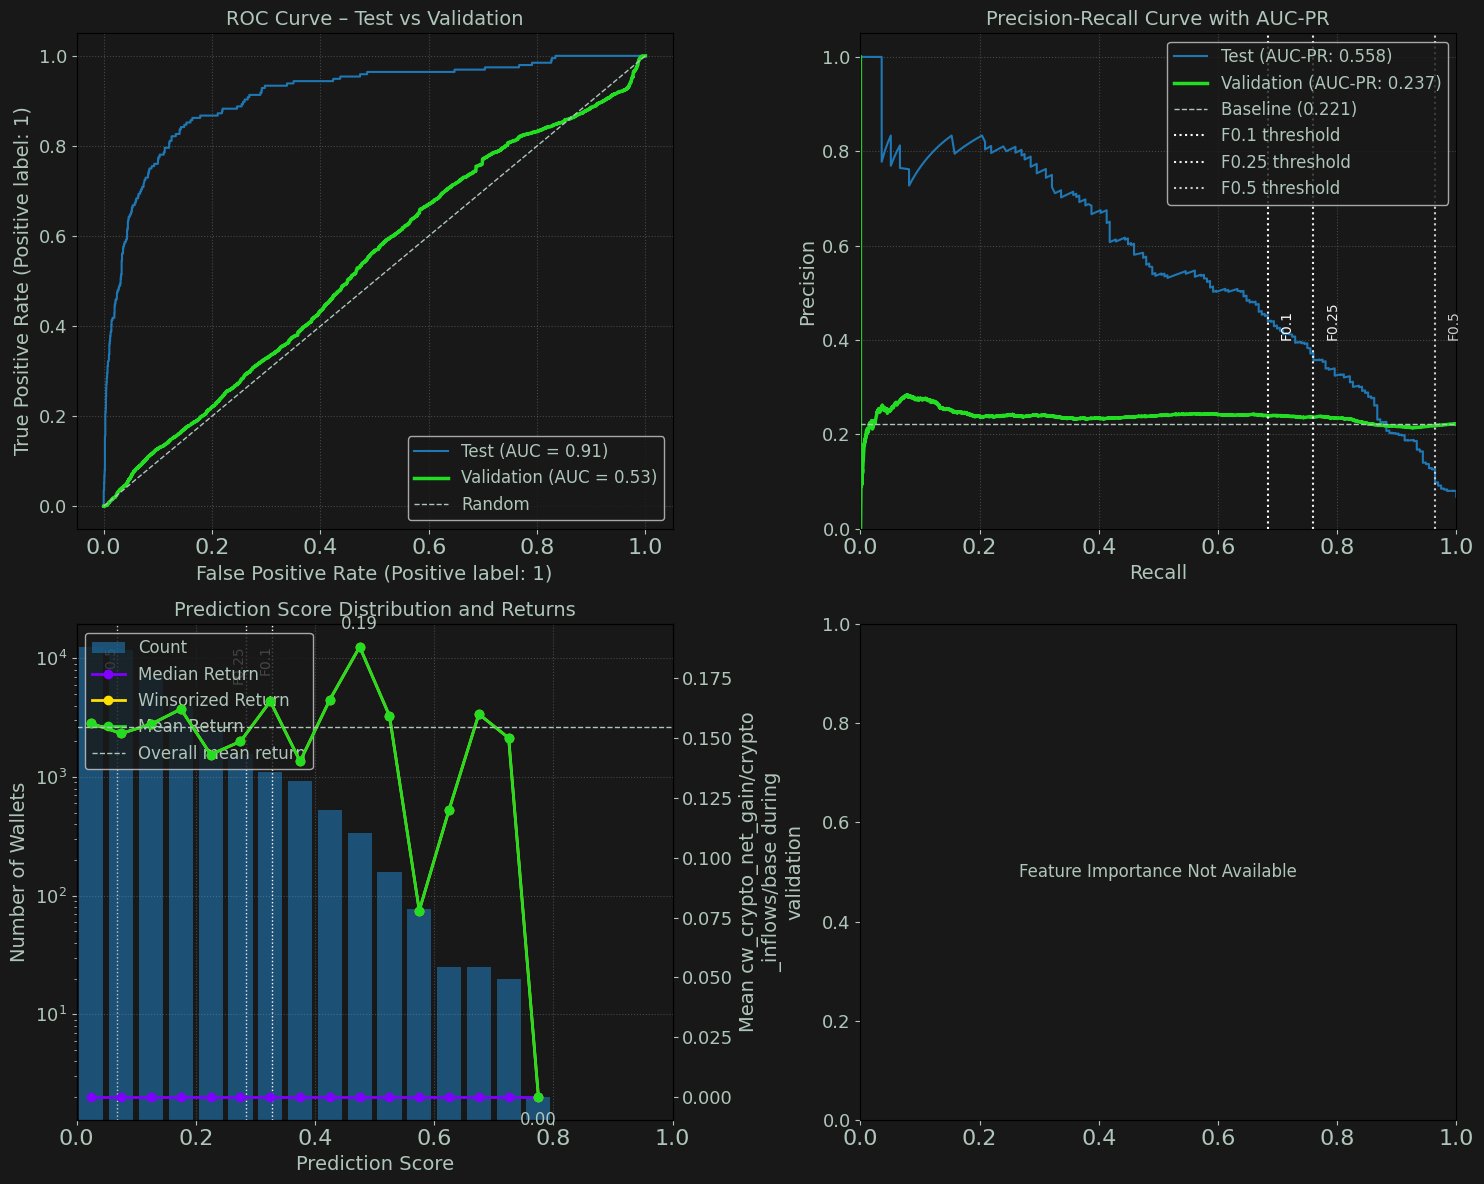

[09/Aug/25 18:35:44] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2024-02-05
---------------------------------------------------


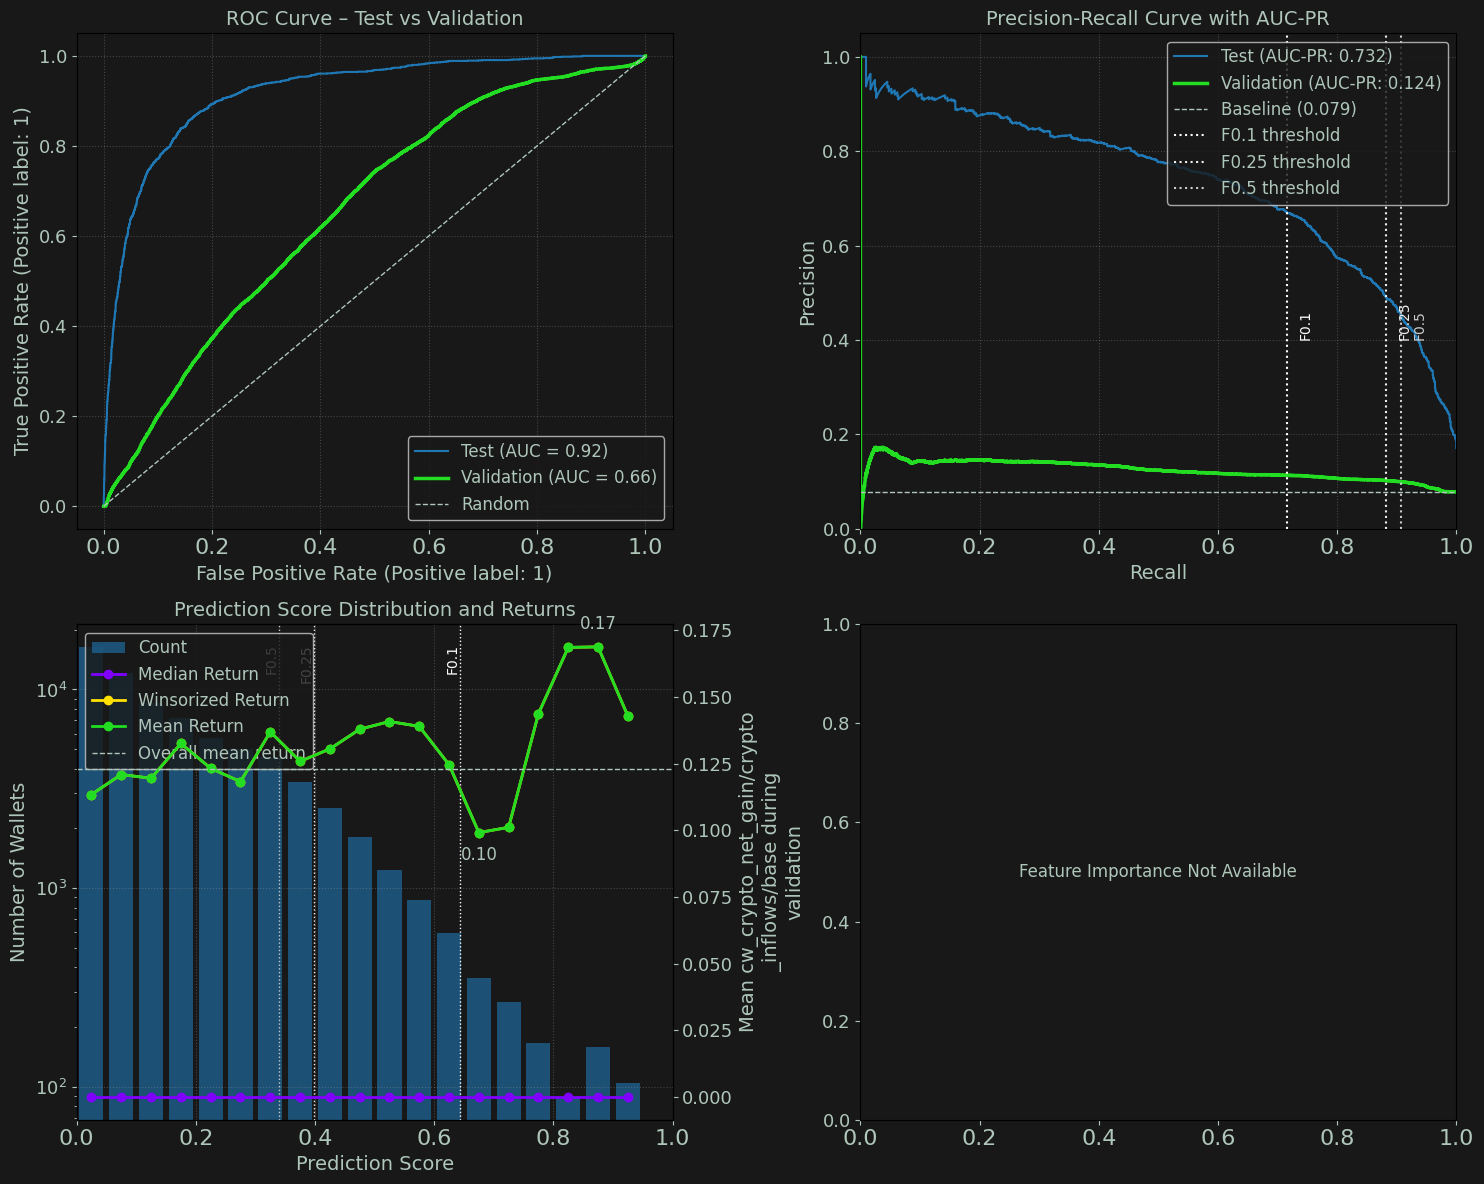

[09/Aug/25 18:35:44] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2024-04-05
---------------------------------------------------


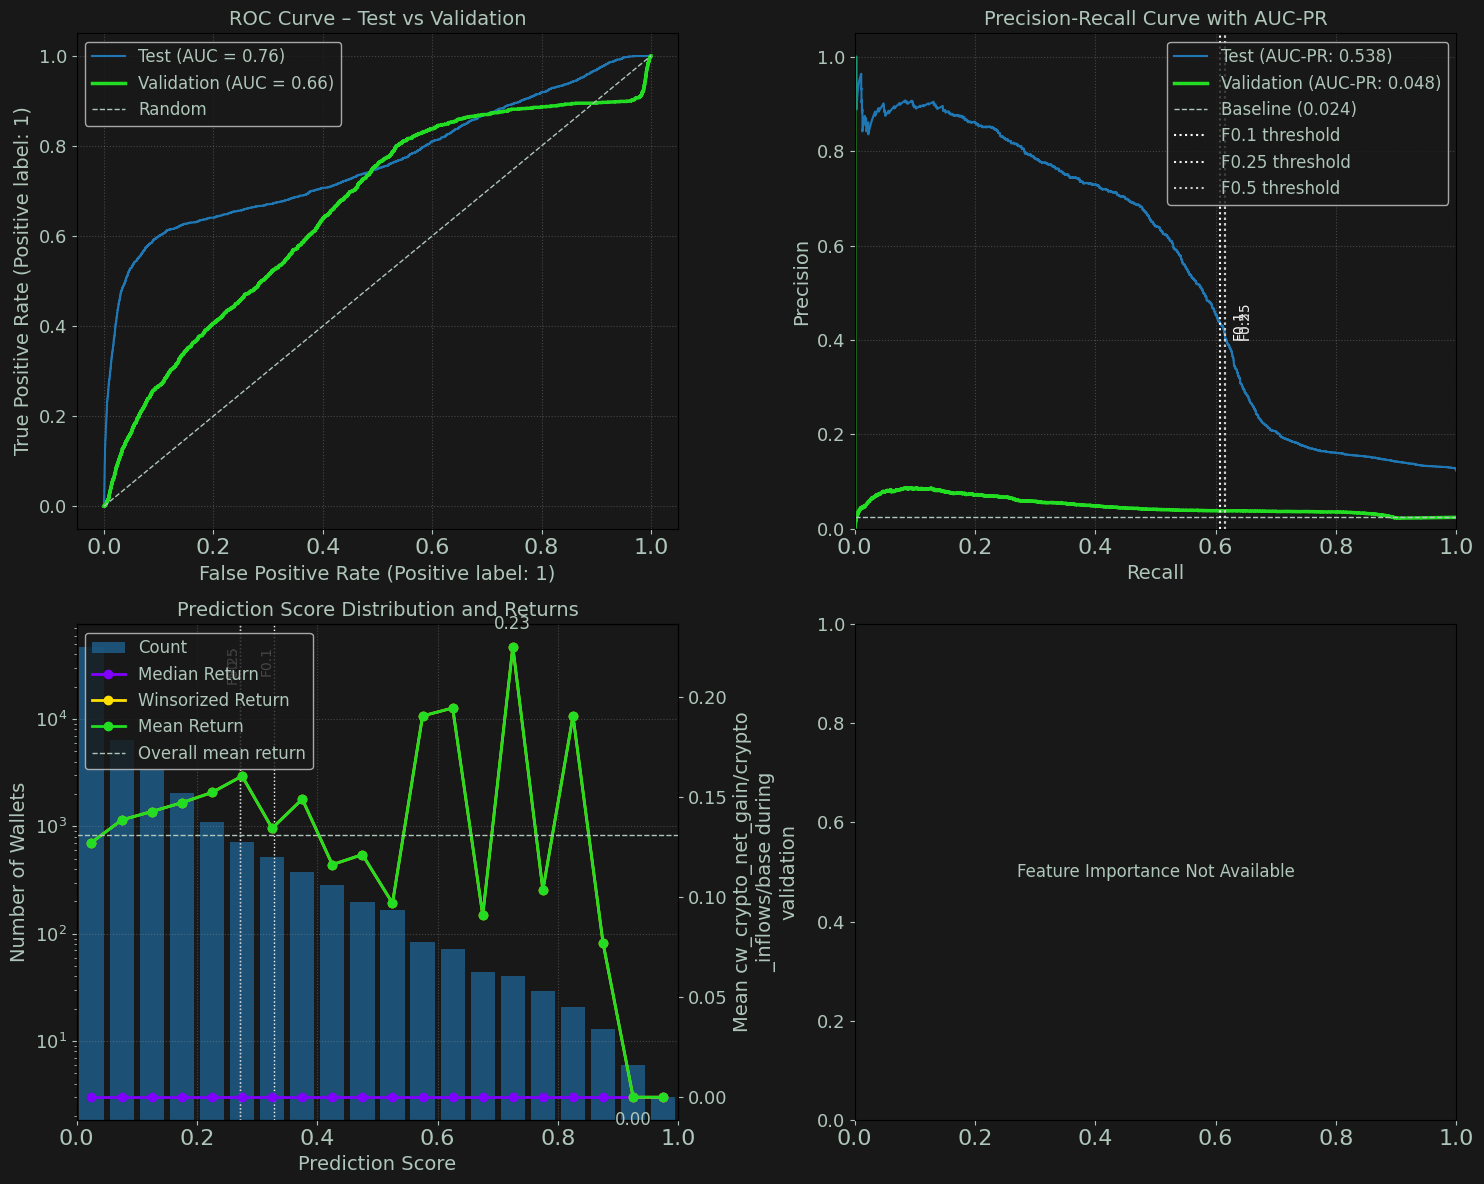

[09/Aug/25 18:35:45] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2024-06-04
---------------------------------------------------


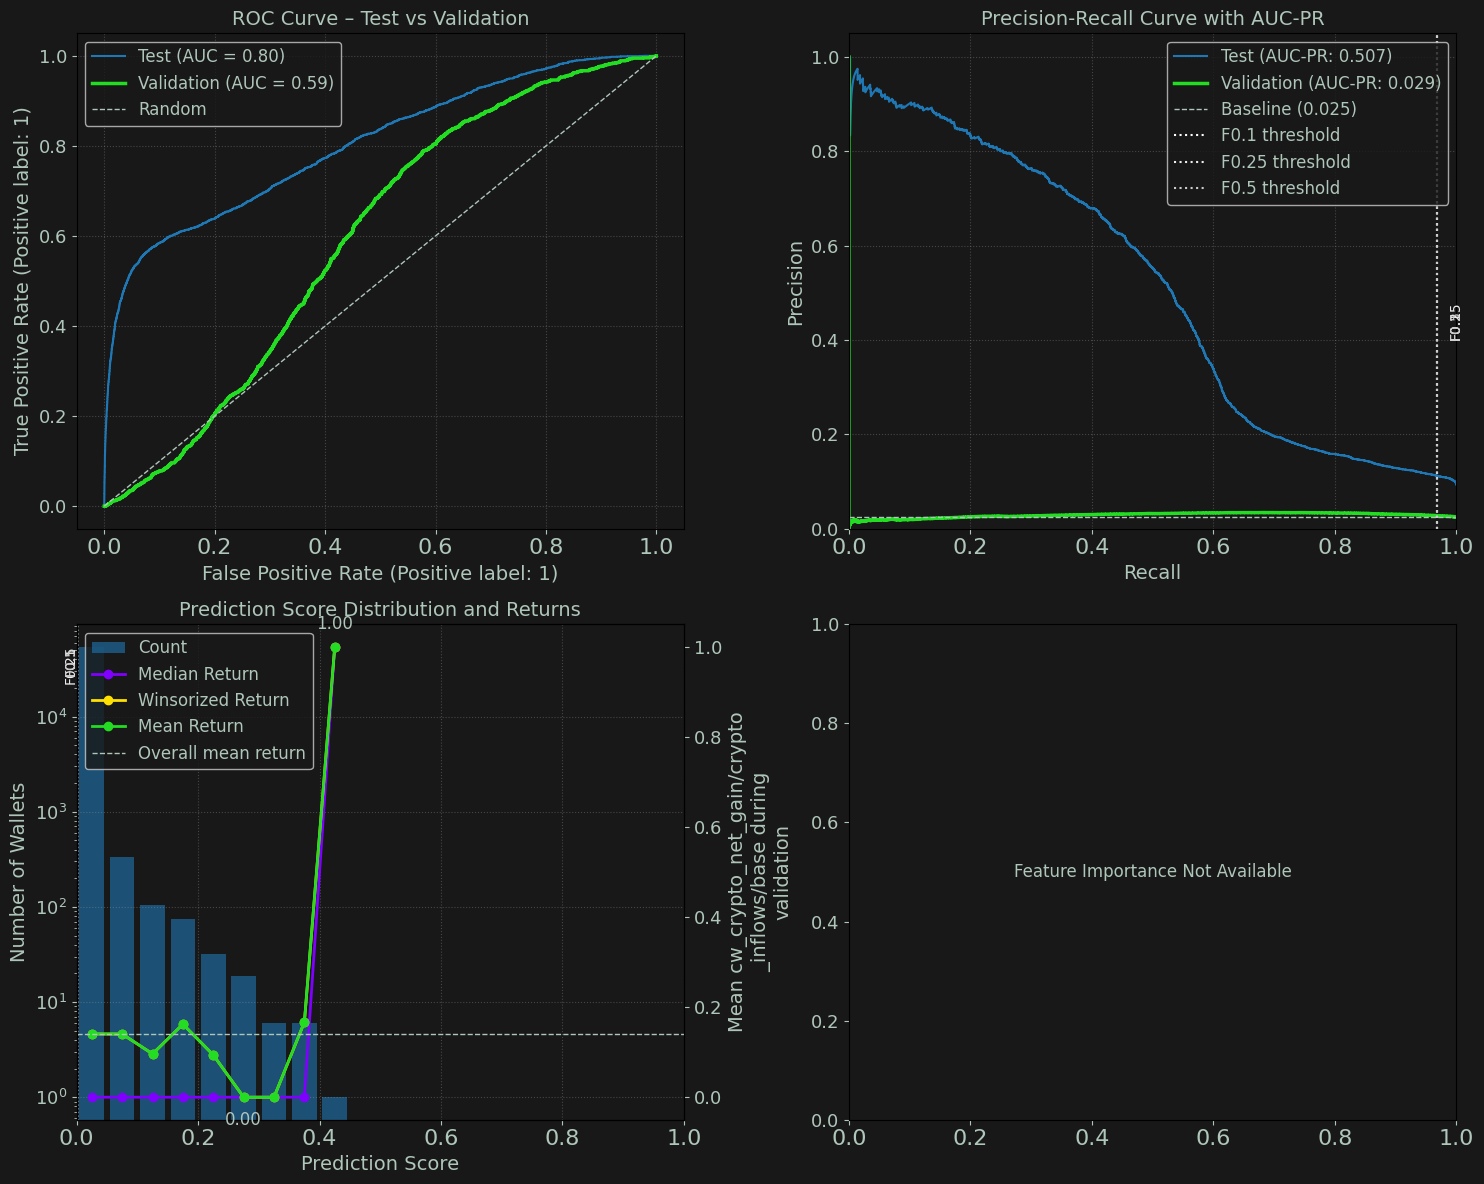

[09/Aug/25 18:35:45] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2024-08-03
---------------------------------------------------


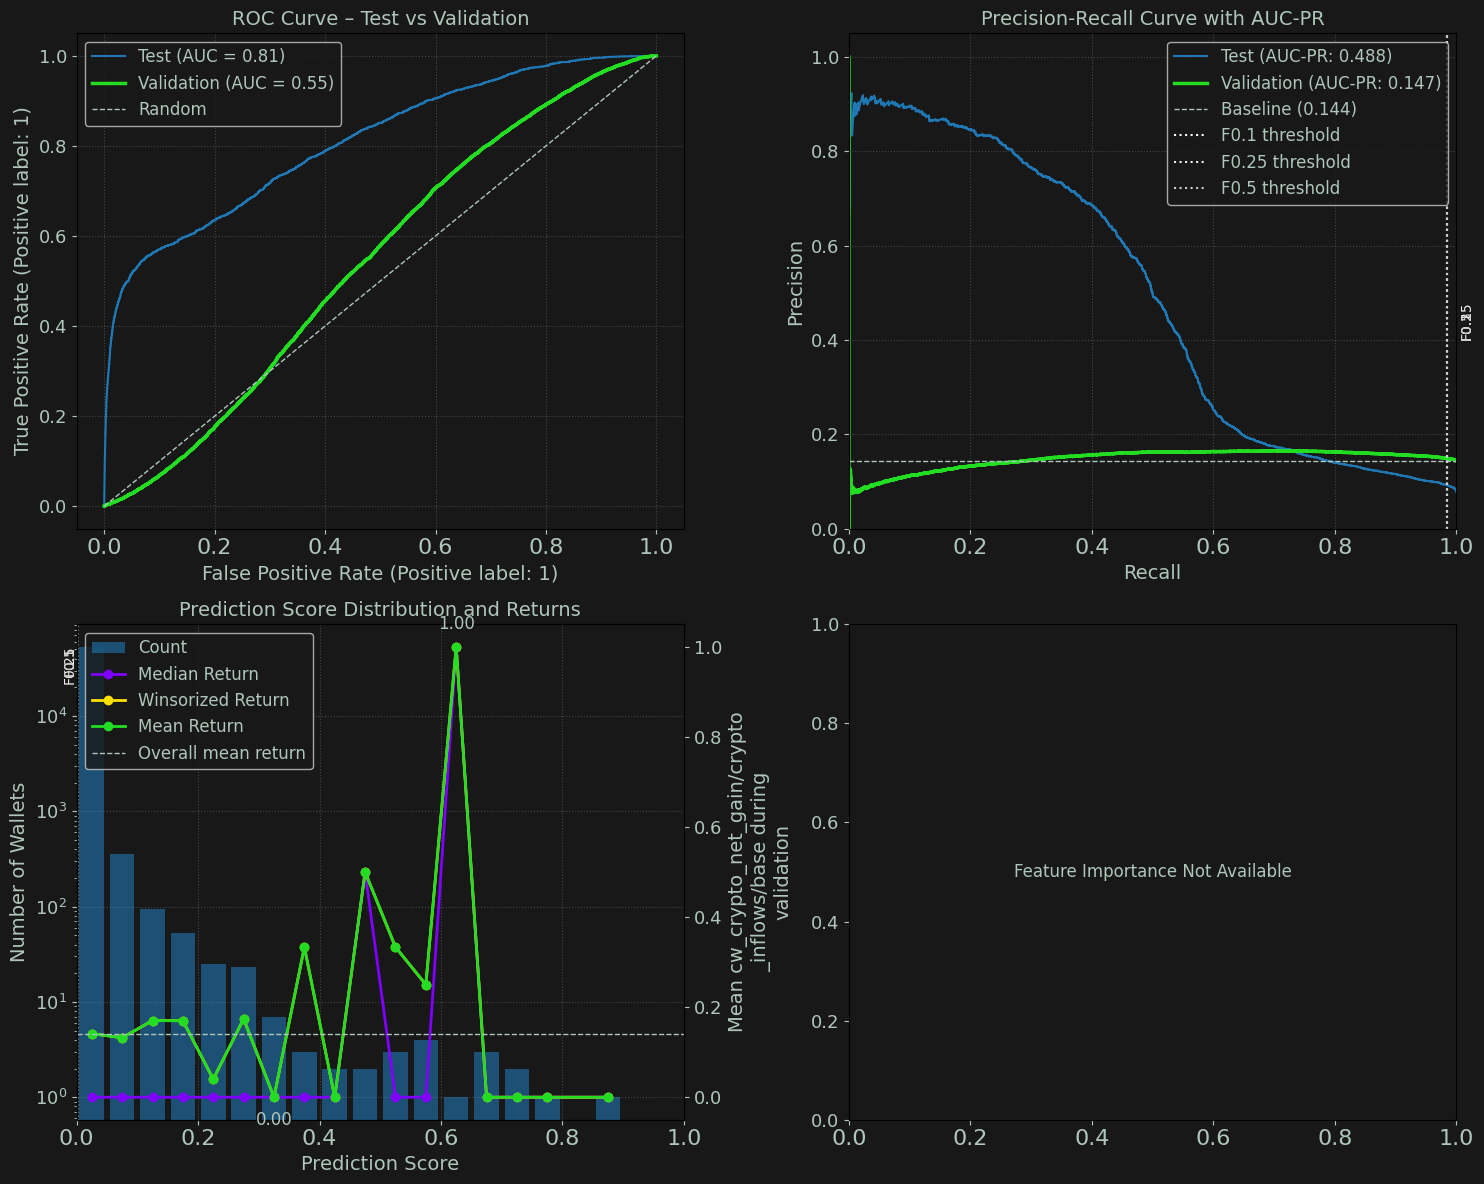

[09/Aug/25 18:35:45] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2024-10-02
---------------------------------------------------


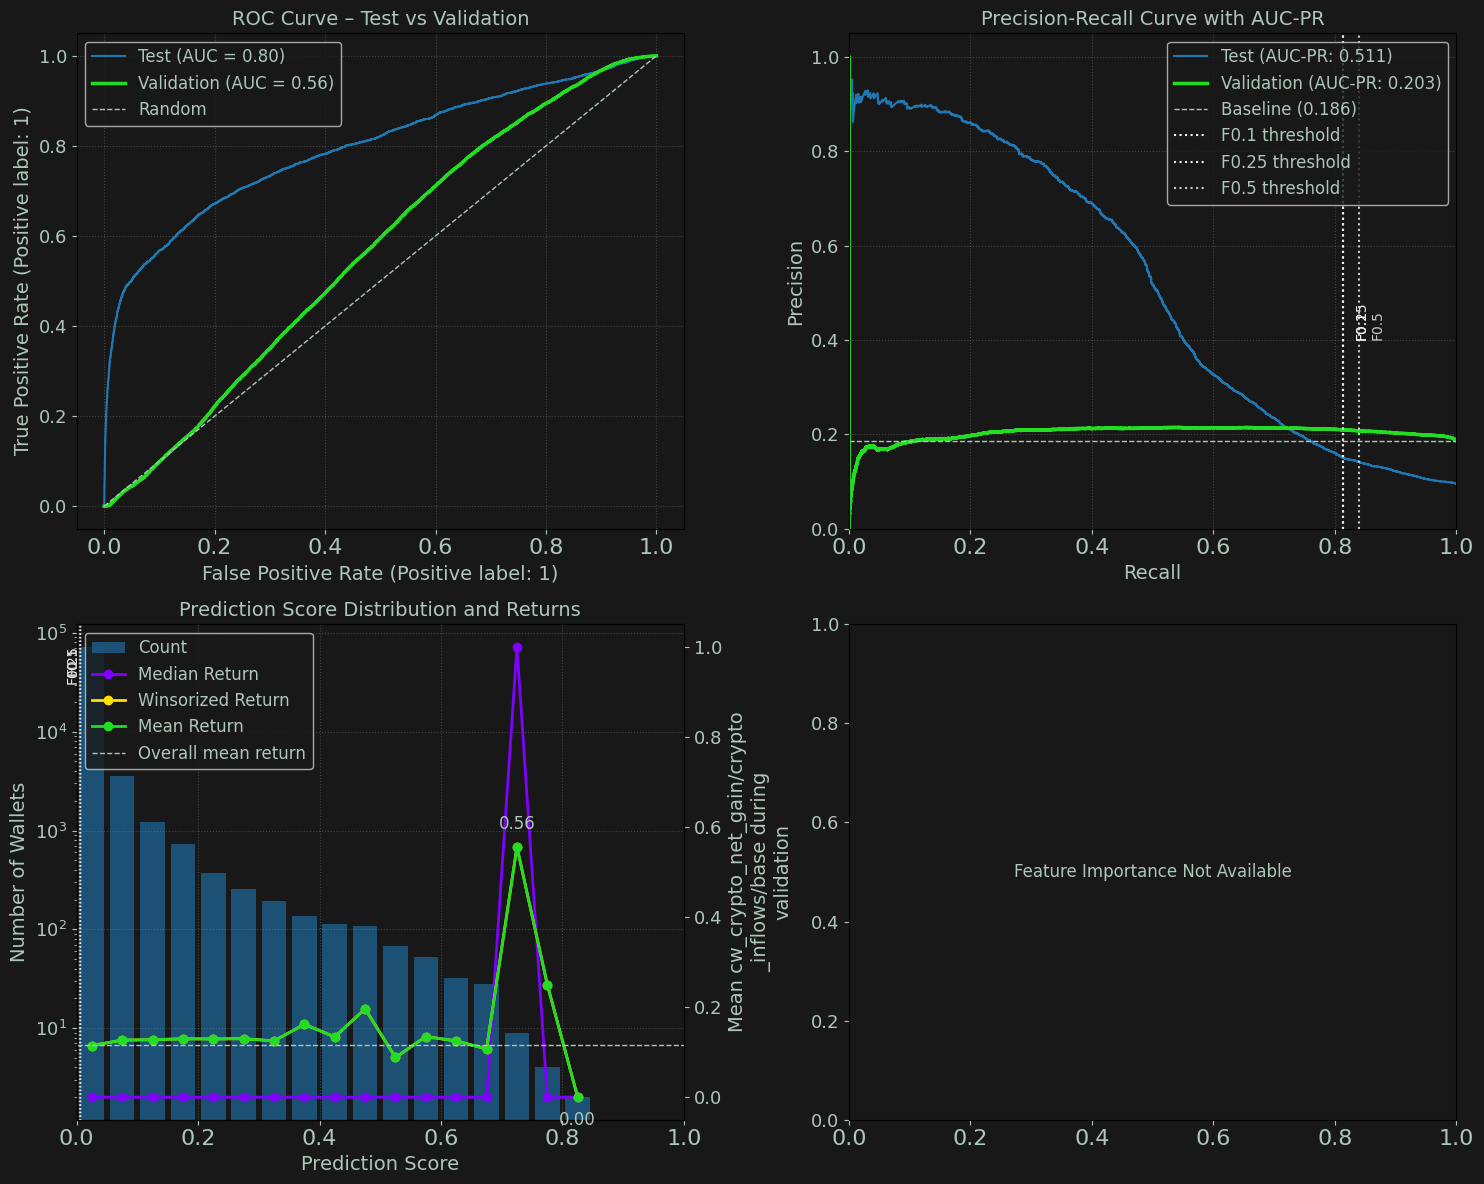

[09/Aug/25 18:35:46] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2024-12-01
---------------------------------------------------


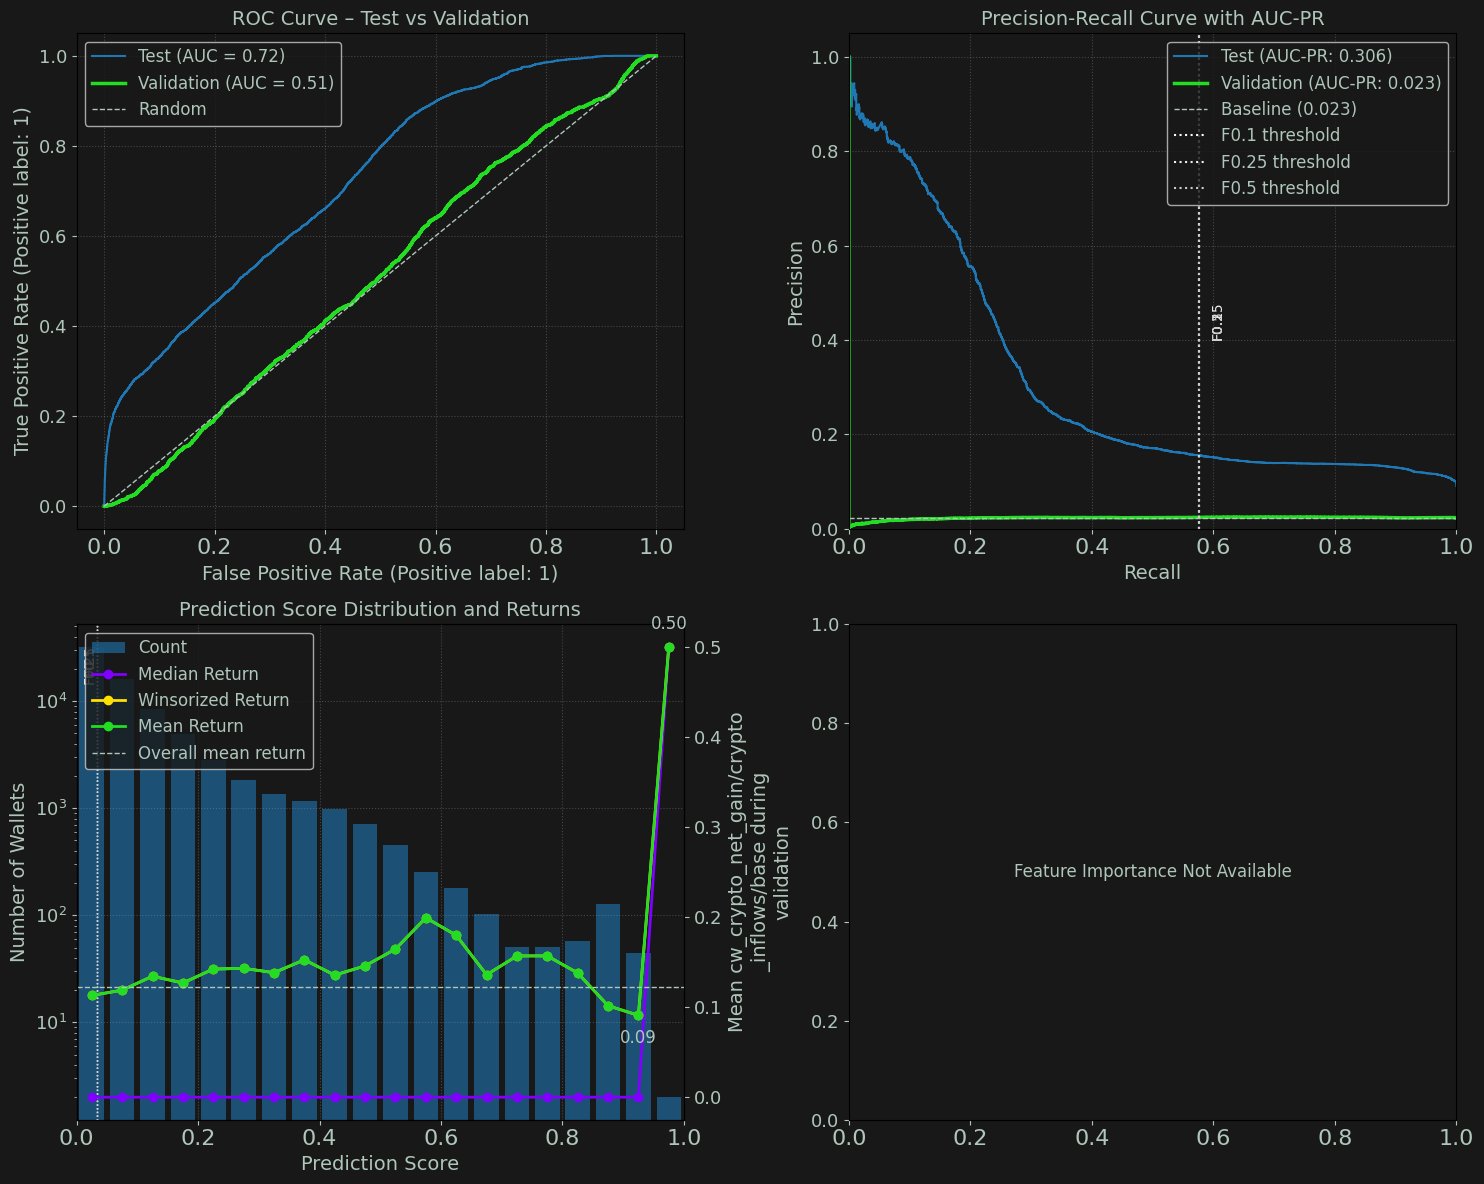

[09/Aug/25 18:35:46] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2025-01-30
---------------------------------------------------


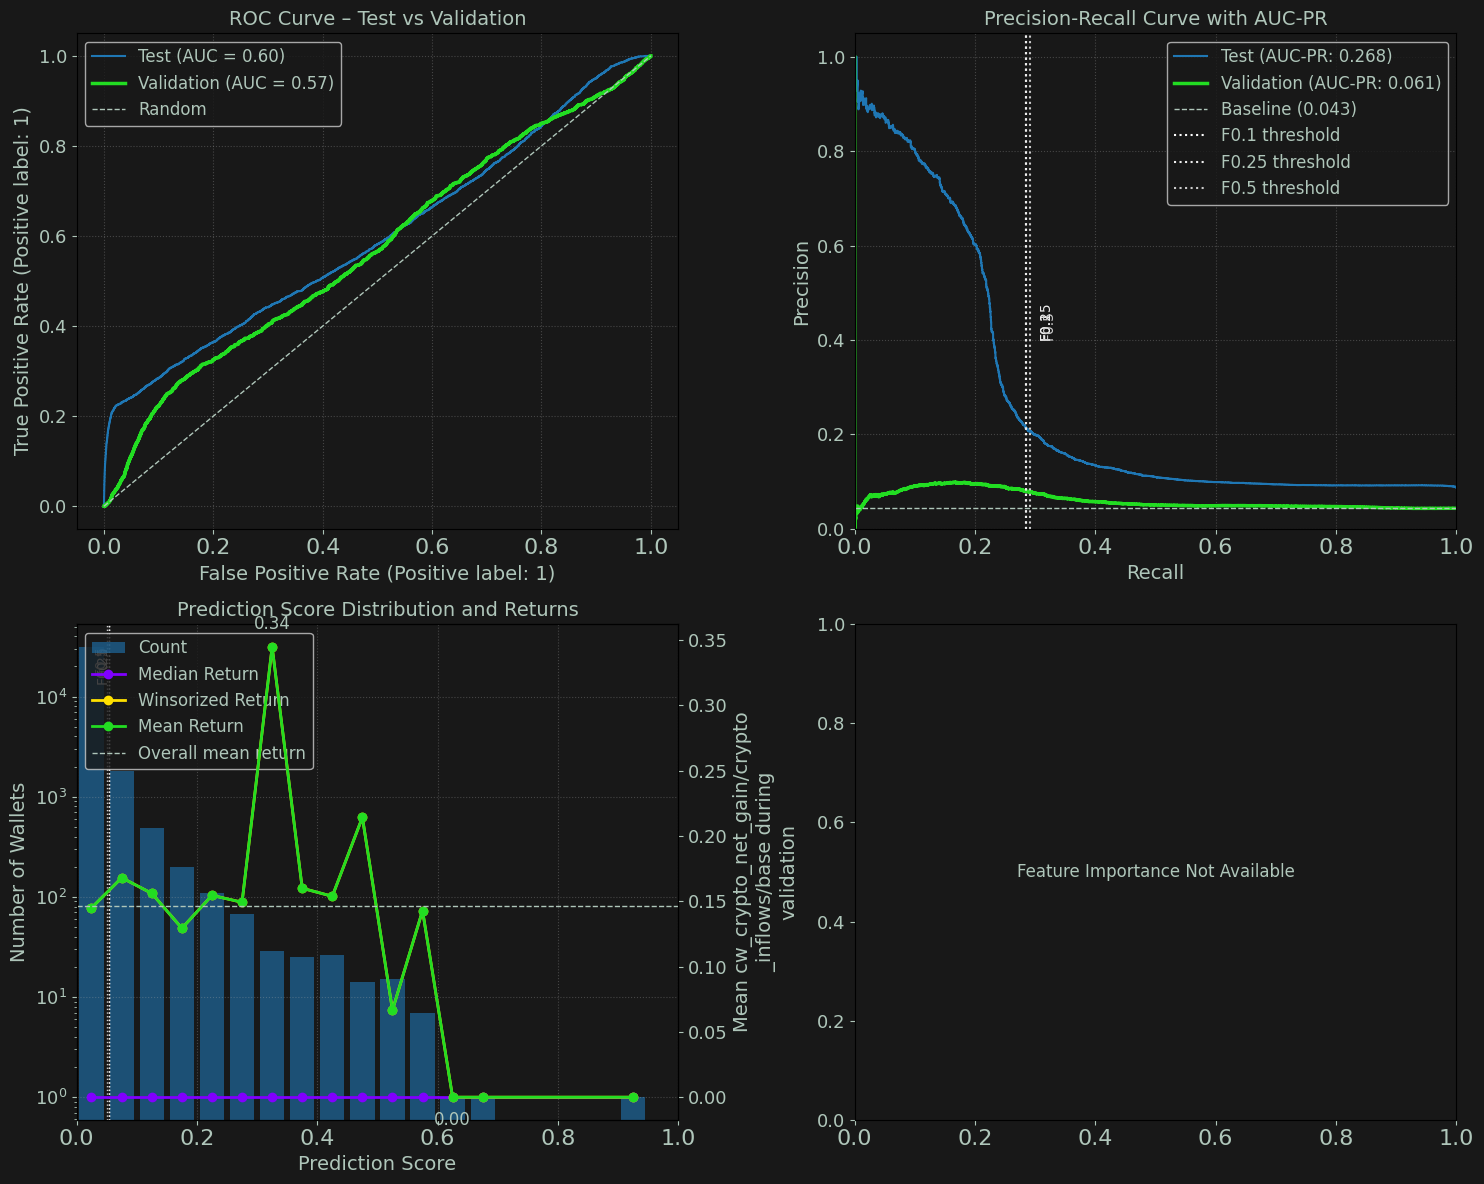

[09/Aug/25 18:35:46] INFO [3060122256.<module>:6] 
Performance over 90 days starting 2025-03-31
---------------------------------------------------


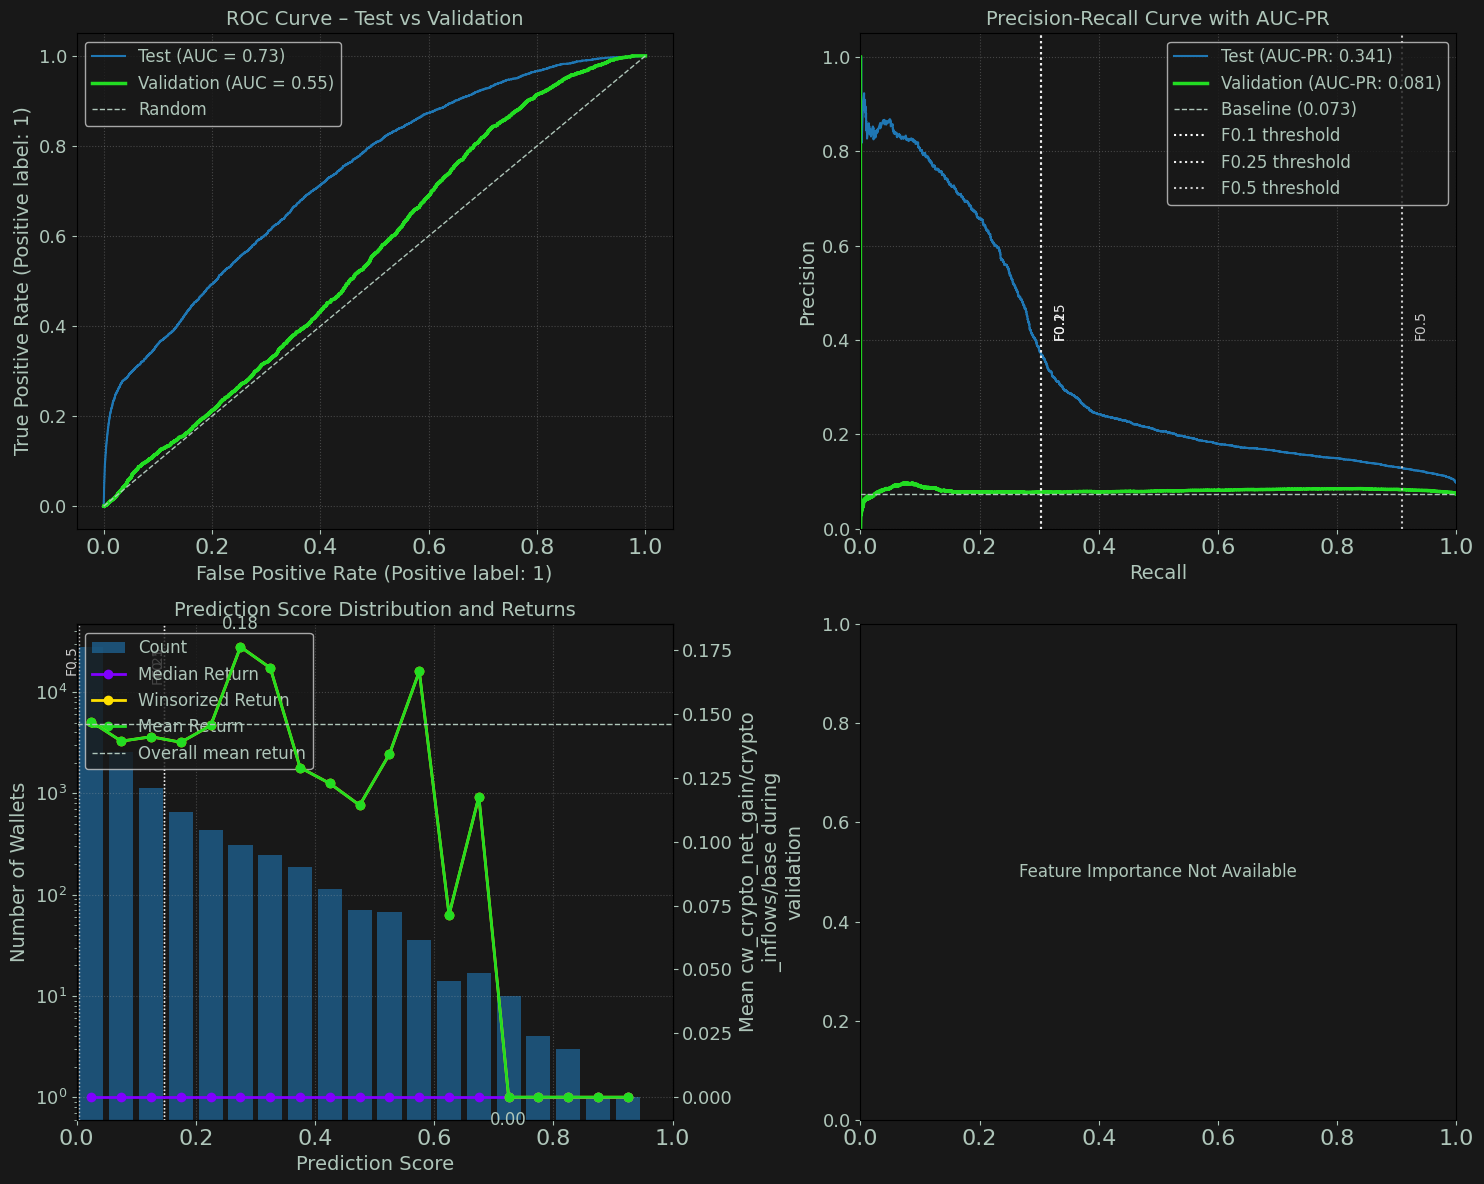

In [17]:
for e in evaluators:
    if not evaluators[e]:
        continue
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    evaluators[e].plot_wallet_evaluation()
    # evaluators[e].summary_report()


In [ ]:
evaluators

In [ ]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    try:
        evaluators[e].plot_wallet_evaluation()
    except:
        continue
    # evaluators[e].summary_report()


In [ ]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    evaluators[e].plot_wallet_evaluation()
    # evaluators[e].summary_report()


In [ ]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    # evaluators[e].plot_wallet_evaluation()
    evaluators[e].summary_report()


In [ ]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    evaluators[e].plot_wallet_evaluation()
    # evaluators[e].summary_report()


In [ ]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%M%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%M-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    # evaluators[e].plot_wallet_evaluation()
    evaluators[e].summary_report()


In [ ]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%M%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%M-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    # evaluators[e].plot_wallet_evaluation()
    evaluators[e].summary_report()


In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts()

#### evaluate all epoch_shifts

In [ ]:
evaluators[-60].summary_report()

In [ ]:
for e in evaluators:
    evaluators[e].plot_wallet_evaluation()


In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()
for e in evaluators:
    evaluators[e].plot_wallet_evaluation()


In [ ]:
evaluators


#### predict and filter data by epoch_shift

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

# Create modeler with epoch_shift as the date_suffix
shift_s3_uris = {f'sh{epoch_shift}': s3_uris['concat']}
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix=f'sh{epoch_shift}',
    s3_uris=shift_s3_uris,
    override_approvals=None
)

# Load the existing concatenated model
model_info = concat_modeler.load_existing_model(epoch_shift=epoch_shift)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

date_suffix = f'sh{epoch_shift}'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
    epoch_shift
)

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


### Single Model Sequence

#### train

In [18]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

[09/Aug/25 19:40:37] INFO [workflow_orchestrator.upload_concatenated_training_data:378] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[09/Aug/25 19:40:37] INFO [workflow_orchestrator.upload_concatenated_training_data:381] Uploading concatenated splits in parallel with 4 threads...
[09/Aug/25 19:40:38] INFO [workflow_orchestrator._upload_split:395] File exists, skipping upload of concatenated split 'val': training-data-concatenated/dda-953-rebuild/val.csv.gz
[09/Aug/25 19:40:38] INFO [workflow_orchestrator._upload_split:395] File exists, skipping upload of concatenated split 'eval': training-data-concatenated/dda-953-rebuild/eval.csv.gz
[09/Aug/25 19:40:38] INFO [workflow_orchestrator._upload_split:395] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-953-rebuild/test.csv.gz
[09/Aug/25 19:40:38] INFO [workflow_orchestrator._upload_split:395] File exists, skipp

2025-08-10 02:40:40 Starting - Starting the training job...
2025-08-10 02:41:11 Downloading - Downloading input data...
2025-08-10 02:41:41 Downloading - Downloading the training image...
2025-08-10 02:42:02 Training - Training image download completed. Training in progress...../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-08-10 02:42:37.967 ip-10-0-208-78.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-08-10 02:42:37.984 ip-10-0-208-78.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-08-10:02:42:38:INFO] Imported framework sagemaker_xgboost_container.training
[2025-08-10:02:42:38:INFO] No GPUs detect

[09/Aug/25 19:45:35] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-953-rebuild/concat/wscr-dda-953--sh0-0809-194038/output/model.tar.gz
[09/Aug/25 19:45:35] INFO [workflow_orchestrator.None:518] (4m56s) Completed train_concatenated_offsets_model.


#### evaluate HPO outcomes

In [ ]:
player = u.AmbientPlayer()
player.stop_all_players()

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [19]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


[09/Aug/25 19:45:35] INFO [wallet_modeler.load_existing_model:147] Loaded model from specified model_uri: s3://wallet-script-models/model-outputs/dda-953-rebuild/concat/wscr-dda-953--sh0-0809-194038/output/model.tar.gz


In [ ]:
model_info

#### predict

In [20]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

pred_results = concat_modeler.batch_predict_test_and_val()

[09/Aug/25 19:45:35] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 19:45:35] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[09/Aug/25 19:45:35] INFO [session.submit:4105] Creating model with name: wscr-dda-953--sh0-0809-194038
[09/Aug/25 19:45:35] INFO [session.submit:4105] Creating model with name: wscr-dda-953--sh0-0809-194038
[09/Aug/25 19:45:36] WARNING [session.submit:4116] Using already existing model: wscr-dda-953--sh0-0809-194038
[09/Aug/25 19:45:36] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-concat-194536-concat-test
[09/Aug/25 19:45:36] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-concat-194536-concat-test
[09/Aug/25 19:45:36] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job: wallet-scoring-concat-194536-concat-val
[09/Aug/25 19:45:36] INFO [session.submit:3962] Creating transform job with name:

..............................................................................................................!

[09/Aug/25 19:50:21] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/concat/wallet-scoring-concat-194536-concat-test/test.csv.gz.out



.

[09/Aug/25 19:50:22] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/concat/test.csv.out.
[09/Aug/25 19:50:22] INFO [wallet_modeler.None:296] (4m46s) Completed predict_with_batch_transform.


..........!

[09/Aug/25 19:51:17] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-953-rebuild/concat/wallet-scoring-concat-194536-concat-val/val.csv.gz.out


[09/Aug/25 19:51:18] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_953_rebuild/concat/val.csv.out.
[09/Aug/25 19:51:18] INFO [wallet_modeler.None:296] (5m43s) Completed predict_with_batch_transform.
[09/Aug/25 19:51:18] INFO [wallet_modeler.None:353] (5m43s) Completed batch_predict_test_and_val.


#### evaluate

In [21]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 0 shift: [1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530]
Unique offset_date values in data: [1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 0 shift: [1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530]
Starting with 41,620 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 8,525,499
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 574 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 574 rows (41,046 remaining)
Co

[09/Aug/25 19:51:55] INFO [615648764.<module>:2] s3://wallet-script-models/model-outputs/dda-953-rebuild/concat/wscr-dda-953--sh0-0809-194038/output/model.tar.gz
[09/Aug/25 19:51:55] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.4 to 
ID: s3://wallet-script-models/model-outputs/dda-953-rebuild/concat/wscr-dda-953--sh0-0809-194038/output/model.tar.gz
Test Samples:             20,024
Val Positive Samples:     1,512 (2.4%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.657  |  0.762
Val Accuracy:               0.969  |  0.890
Val Precision:              0.046  |  0.553
Val Recall:                 0.015  |  0.551
Val F1 Score:               0.022  |  0.552

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n/a |   

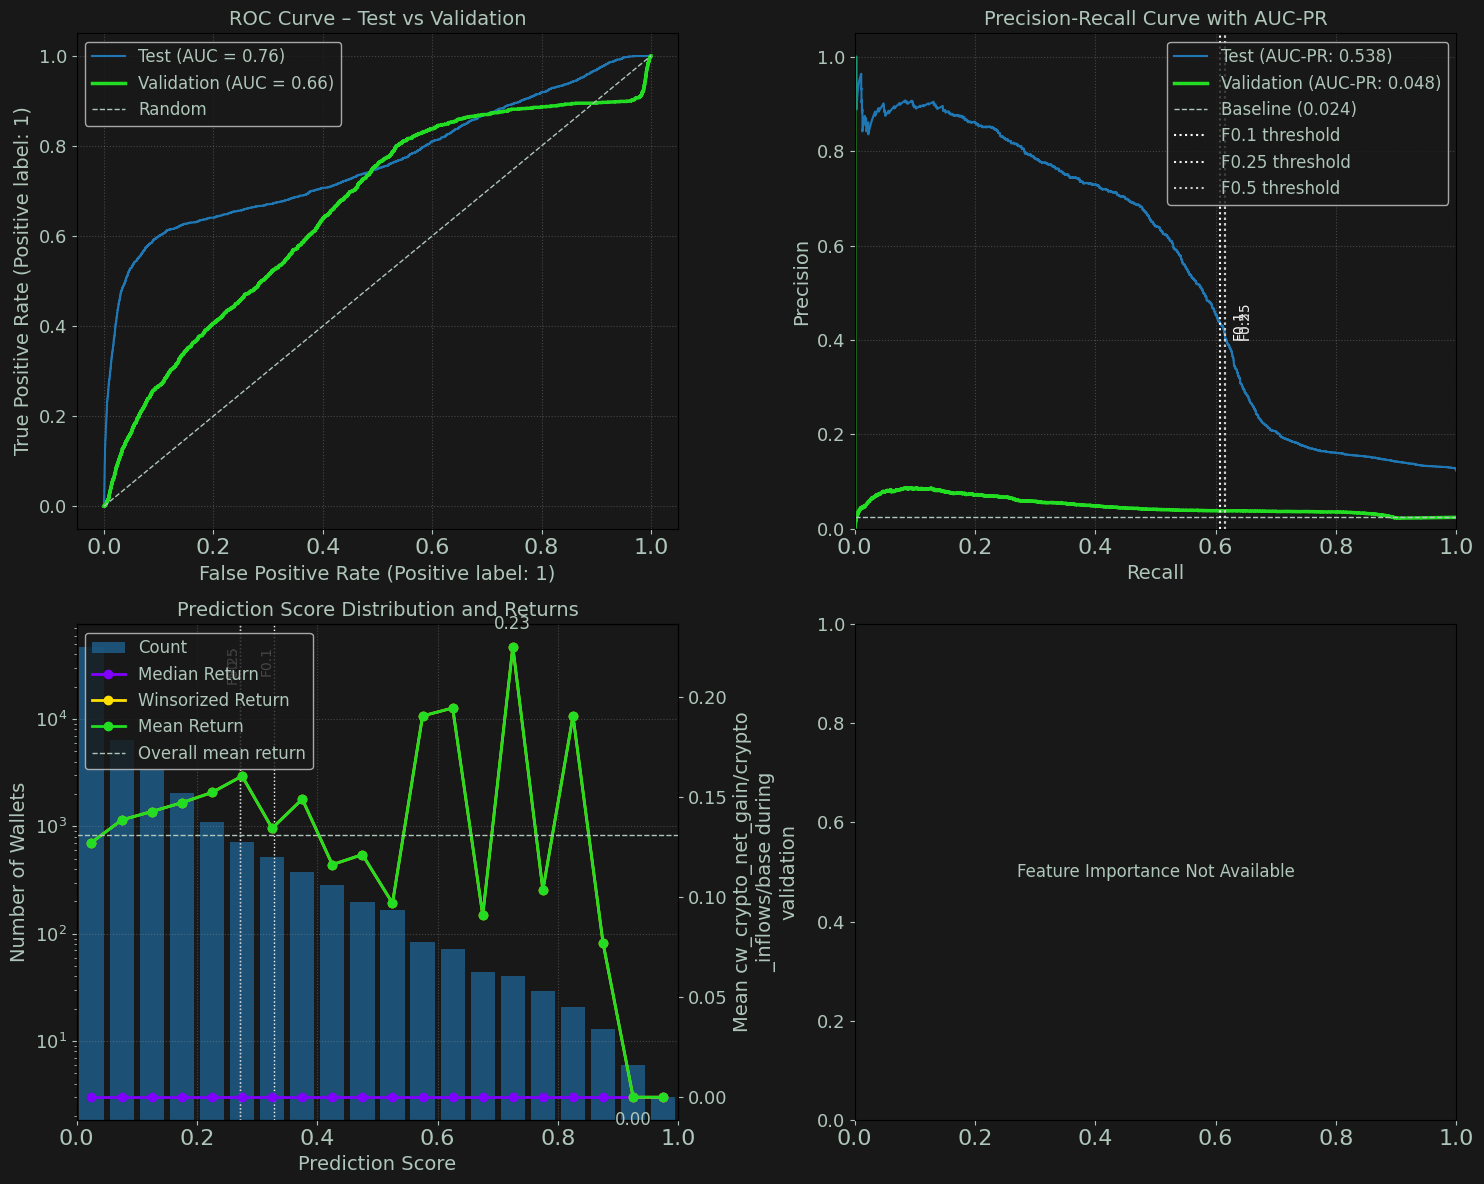

: 

In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable